In [67]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook # progress bar
# from konlpy.tag import Mecab #Okt 등 형태소 분석기 불러오기
from konlpy.tag import Okt #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# csv로 data 읽어오기
total_data = pd.read_csv('data_te.csv', encoding='ANSI')
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 54080


In [5]:
# 4~5 별점 data만 남기고 나머지는 0
total_data['label'] = np.select([total_data.star > 3], [1], default=0)

In [6]:
# 중복 제외 sample count
total_data['star'].nunique(), total_data['REVIEW'].nunique(), total_data['label'].nunique()

(5, 53724, 2)

In [7]:
# 중복 sample 제거
total_data.drop_duplicates(subset=['REVIEW'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 53724


In [8]:
# null값 check
print(total_data.isnull().values.any())
print(total_data.isnull().sum())

False
DATE      0
REVIEW    0
star      0
label     0
dtype: int64


<AxesSubplot:>

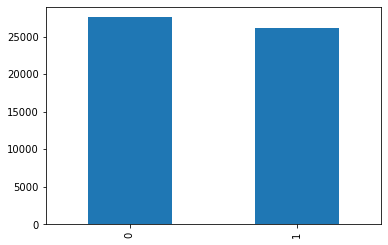

In [9]:
# 0이 부정, 1이 긍정
total_data['label'].value_counts().plot(kind = 'bar')

In [10]:
# 한글과 공백을 제외하고 모두 제거
total_data['REVIEW'] = total_data['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
total_data['REVIEW'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
# null값 체크
print(total_data.isnull().sum())
# 전처리 후 데이터 샘플 확인
print('전처리 후 train용 샘플의 개수 :',len(total_data))

DATE       0
REVIEW    23
star       0
label      0
dtype: int64
전처리 후 train용 샘플의 개수 : 53724
<ipython-input-10-1d29ac1adfe3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  total_data['REVIEW'] = total_data['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [12]:
total_data = total_data.dropna(how='any') # Null 값 제거
# null값 체크
print(total_data.isnull().sum())
# 전처리 후 데이터 샘플 확인
print('전처리 후 전체 데이터 개수 :',len(total_data))

DATE      0
REVIEW    0
star      0
label     0
dtype: int64
전처리 후 전체 데이터 개수 : 53701


In [13]:
with open('total_data_te.pickle', 'wb') as f:
    pickle.dump(total_data, f, pickle.HIGHEST_PROTOCOL)

In [16]:
total_data_review = total_data['REVIEW'].tolist()
with open("total_data_te_review.pickle", "wb") as f:
    pickle.dump(total_data_review, f)

-----------------------------------------------
## gensim으로 플레이스토어 리뷰 토픽 모델링 
- 1. 토픽 모델링을 적용하기 위해 텍스트를 전처리
- 2. gensim을 사용한 토픽 모델링 

### 1. 토픽 모델링을 위한 라이브러리 불러오기

In [14]:
from tqdm import tqdm_notebook # progress bar
# from konlpy.tag import Mecab #Okt 등 형태소 분석기 불러오기
from konlpy.tag import Okt #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 2. 텍스트 전처리 함수 만들기

In [50]:
# def read_documents(input_file_name):    
#     corpus = []    
    
#     with open(input_file_name, 'rb') as f:
#         temp_corpus = pickle.load(f)
        
#     for page in temp_corpus:
#         corpus += page
    
#     return corpus

def text_cleaning(docs):
    # 한국어를 제외한 글자를 제거하는 함수.
    for doc in docs:
        doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))

    return docs

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1.
    for i in string.punctuation:
        SW.add(i)
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가    
    with open(path) as f:
        for word in f:
            SW.add(word)
    return SW

def text_tokenizing(corpus, tokenizer):    
    okt = Okt()
    token_corpus = []    

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = okt.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]                
            token_corpus.append(token_text)
            
    elif tokenized == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = okt.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)        

    return token_corpus

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
input_file_name = "total_data_te_review.pickle"

# documents = read_documents(input_file_name)
with open(input_file_name, 'rb') as f:
    documents = pickle.load(f)
# print(documents)
# SW = define_stopwords("stopwords.pickle")
SW = ['거','할','때','그','제','계속','하면','한','고','하','임','요','더','으로','이나','잘','어떻게','도','인','진짜','과','해서','겜','은','형','부터','있습니다','다시','의','근데','에','죠','리뷰','듯','게','것','이','로','는','입니다','그리고','있는데','게임','가','다','이라','지','에서','이건','네','수','점','를','하고','나','중','같아요','들','이거','개','만','하는','합니다','생각','까지','하나','을','면','와','쿠키런','오븐브레이크']
cleaned_text = text_cleaning(documents)
tokenized_text = text_tokenizing(cleaned_text, tokenizer="noun") #tokenizer= "noun" or "word"

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-50-6bc1cb956750>:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):


Preprocessing:   0%|          | 0/53701 [00:00<?, ?it/s]

In [32]:
print(SW)

{'"', '_', '^', '-', '거,할,때,그,제,계속,하면,한,고,하,임,요,더,으로,이나,잘,어떻게,도,인,진짜,과,해서,겜,은,형,부터,있습니다,다시,의,근데,에,죠,리뷰,듯,게,것,이,로,는,입니다,그리고,있는데,게임,가,다,이라,지,에서,이건,네,수,점,를,하고,나,중,같아요,들,이거,개,만,하는,합니다,생각,까지,하나,을,면,와', '(', ';', "'", ':', ',', '*', '=', '\\', '|', '/', '@', '#', '}', '[', '.', '$', '`', '%', ')', '&', '{', '!', ']', '<', '?', '+', '~', '>'}
C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3. 토픽 모델링에 사용할 행렬 생성

### 1) 문서-단어 행렬(DTM, document-term matrix) 생성

In [53]:
# 어휘(vocabulary) 학습
dictionary = corpora.Dictionary(tokenized_text)

# 문서-단어 행렬(document-term matrix) 생성
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
print(dictionary)

Dictionary(21055 unique tokens: ['내의', '다시키', '문의', '서버', '신규']...)
C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
corpus[0][:5]

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

### 2) TFIDF 문서-단어 행렬 생성

In [56]:
# TFIDF 문서-단어 행렬 생성
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0][:5]

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.43848242308299257),
 (1, 0.4602087279915867),
 (2, 0.2561148728268616),
 (3, 0.173563702119514),
 (4, 0.2461674958762195)]

### 4.  LDA 모델 생성

In [57]:
model = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary)

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
model.show_topic(0, 10)

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('캐릭터', 0.016748982),
 ('버그', 0.015586318),
 ('유저', 0.014664922),
 ('서버', 0.014376281),
 ('사람', 0.013899493),
 ('운영', 0.011507443),
 ('계정', 0.011074593),
 ('제발', 0.0097749345),
 ('보상', 0.00949487),
 ('카카오', 0.00903224)]

In [59]:
model.show_topic(1, 10)

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('업데이트', 0.06376241),
 ('애니', 0.023702543),
 ('시간', 0.019035568),
 ('와이파이', 0.017176978),
 ('화면', 0.0164466),
 ('오류', 0.014072143),
 ('자꾸', 0.01388441),
 ('시작', 0.012974335),
 ('접속', 0.0111332275),
 ('문제', 0.010361167)]

In [60]:
model.show_topic(2, 10)

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('정말', 0.030871732),
 ('오븐', 0.021176102),
 ('쿠키', 0.020130567),
 ('브레이크', 0.016812999),
 ('이벤트', 0.015413805),
 ('플레이', 0.012198234),
 ('카카오', 0.010891284),
 ('친구', 0.009780681),
 ('지금', 0.009128505),
 ('보물', 0.008872427)]

In [61]:
model.show_topic(3, 10)

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('캐릭터', 0.024875427),
 ('스토리', 0.02291558),
 ('과금', 0.021940954),
 ('재미', 0.02019388),
 ('확률', 0.018612014),
 ('현질', 0.018191861),
 ('애니메이션', 0.017869813),
 ('뽑기', 0.012619628),
 ('유저', 0.011527101),
 ('보석', 0.011307712)]

### 5. 토픽 모델링을 추가하여 코드 완성하기

In [62]:
# 토픽 개수, 키워드 개수를 정해주는 변수를 추가.
NUM_TOPICS = 3 # 토픽의 수

NUM_TOPIC_WORDS = 30 # 키워드 수

def build_doc_term_mat(documents):
    # 문서-단어 행렬 만들어주는 함수.
    print("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]        
    return corpus, dictionary

def print_topic_words(model):
    # 토픽 모델링 결과를 출력해 주는 함수.
    print("\nPrinting topic words.\n")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        
        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))            
        print("\n")

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# 1) document-term matrix 생성
corpus, dictionary = build_doc_term_mat(tokenized_text)

# 2) LDA 모델 생성
model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, alpha="auto", eta="auto")

# 3) 결과를 출력.
print_topic_words(model)

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building document-term matrix.

Printing topic words.

Topic ID: 0
	캐릭터	0.02900039590895176
	재미	0.026444345712661743
	애니	0.021653542295098305
	확률	0.020353494212031364
	뽑기	0.015004019252955914
	그래픽	0.011191220954060555
	캐릭	0.009863789193332195
	그냥	0.009769738651812077
	쥬얼	0.009121225215494633
	이벤트	0.008358721621334553
	사람	0.008172805421054363
	조작	0.00753259239718318
	친구	0.00717393821105361
	보물	0.006564924959093332
	플레이	0.006418098695576191
	레드	0.0063661979511380196
	쿠키	0.0060931057669222355
	완전	0.00586477667093277
	옛날	0.00585984019562602
	느낌	0.005840905476361513
	크리스탈	0.005469333380460739
	정말	0.005028499756008387
	전체	0.00476

### 6. pyLDAvis를 통한 토픽 모델링 결과 시각화하기

In [64]:
#!pip install pyLDAvis

C:\Users\zebok\Anaconda3\envs\chris\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data
pyLDAvis.save_html(data, './output_html/topic.html')